## Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

Использовал данный датасет - https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

Цель классификации - предсказать, будет ли клиент подписываться (да/нет) на срочный депозит (переменная y).

#### сделать обзорный анализ выбранного датасета

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


__Информация о наборе данных:__

Данные связаны с прямыми маркетинговыми кампаниями португальского банковского учреждения. Маркетинговые кампании основаны на телефонных звонках. Часто для того, чтобы получить доступ к продукту (банковский срочный депозит), необходимо было связаться с одним и тем же клиентом, если клиент согласится на продукт (банковский срочный депозит) ("да") или не согласится ("нет") на подписку.

bank-full.csv со всеми примерами и 17 признаками, упорядоченными по дате (старая версия этого набора данных с меньшим количеством признаков).

__Цель классификации__ - предсказать, будет ли клиент подписываться (да/нет) на срочный депозит (переменная y).

__Attribute Information:__

Input variables:

bank client data:

    1 - age (numeric)
    2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
    3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
    4 - education (categorical: 'tertiary','secondary','unknown','primary')
    5 - default: has credit in default? (categorical: 'no','yes','unknown')
    6 - balance: (numeric)
    7 - housing: has housing loan? (categorical: 'no','yes','unknown')
    8 - loan: has personal loan? (categorical: 'no','yes','unknown')

related with the last contact of the current campaign:
    
    9 - contact: contact communication type (categorical: 'cellular','telephone')
    10 - day: (numeric)
    11 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
    12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

other attributes:

    13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
    14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
    15 - previous: number of contacts performed before this campaign and for this client (numeric)
    16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
    17 - y - has the client subscribed a term deposit? (binary: 'yes','no')

In [3]:
df.shape

(45211, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [8]:
# Числовые переменные
num_vars = df.select_dtypes(include=['int64'])

# Категориальные переменные
cat_vars = [i for i in df.columns if i not in num_vars]
cat_vars.remove('y')
target = 'y'

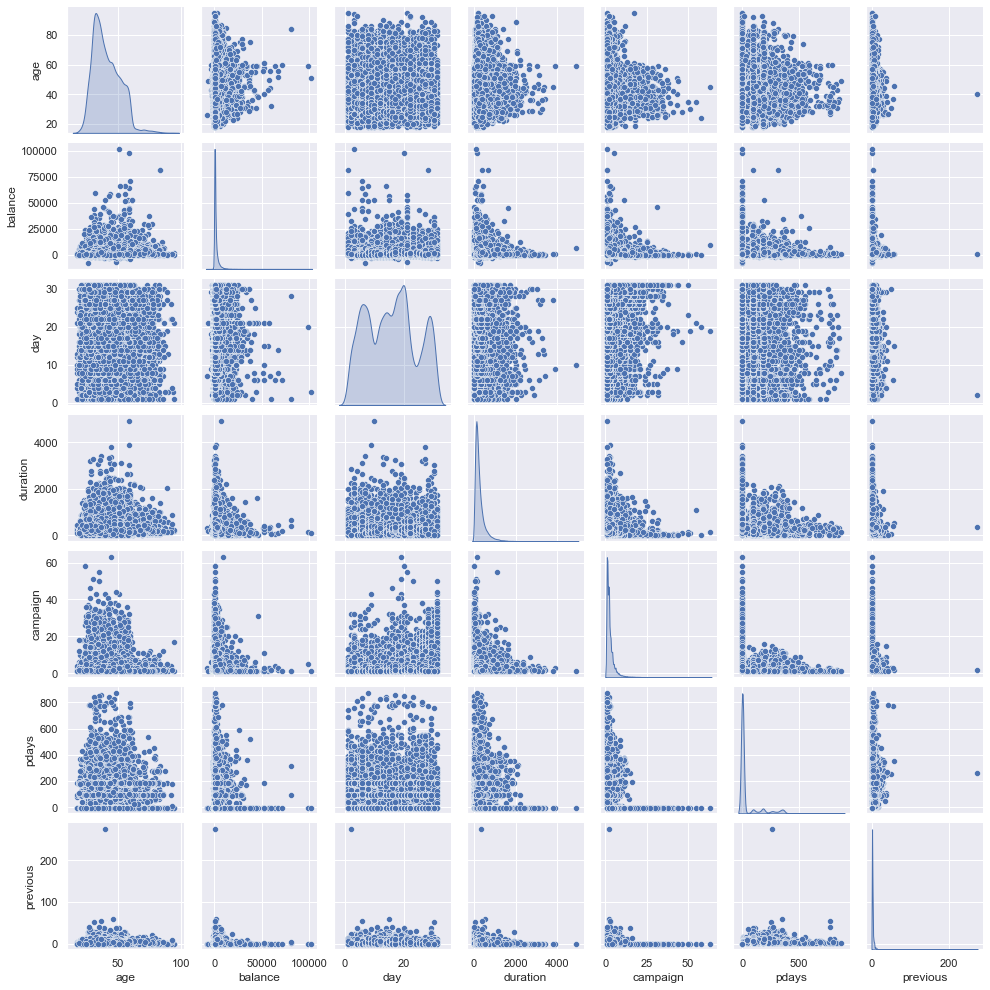

In [14]:
sns.set()
columns = [
    "age",
    "balance",
    "day",
    "duration",
    "campaign",
    "pdays",
    "previous"
]

sns.pairplot(df[columns], height=2, kind="scatter", diag_kind="kde")
plt.show()

Categorical Variable: job


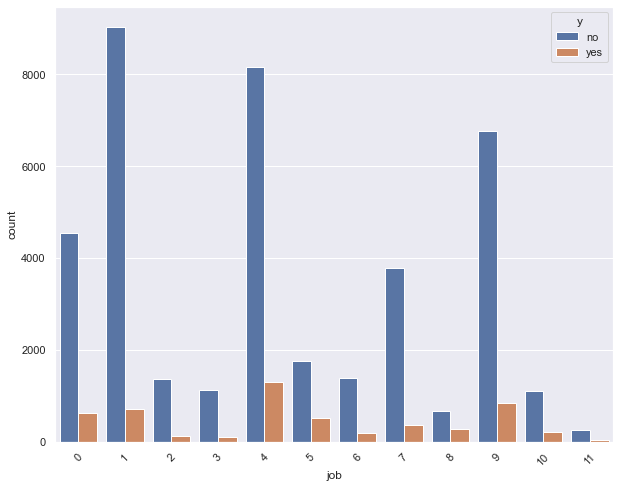

Categorical Variable: marital


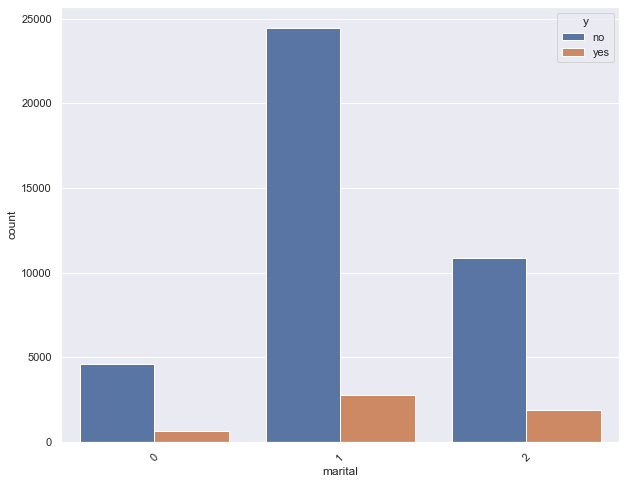

Categorical Variable: education


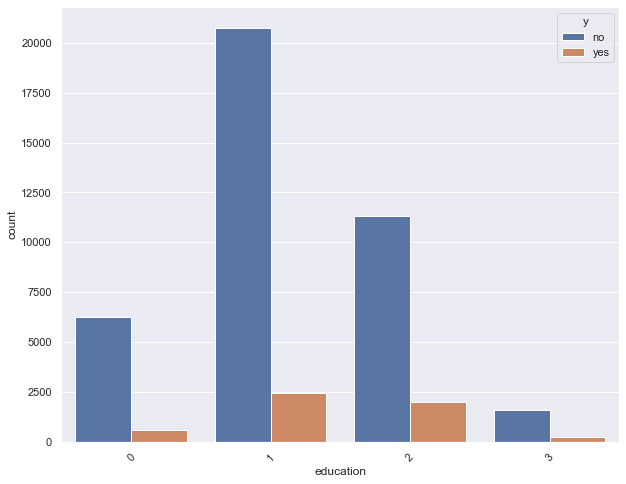

Categorical Variable: default


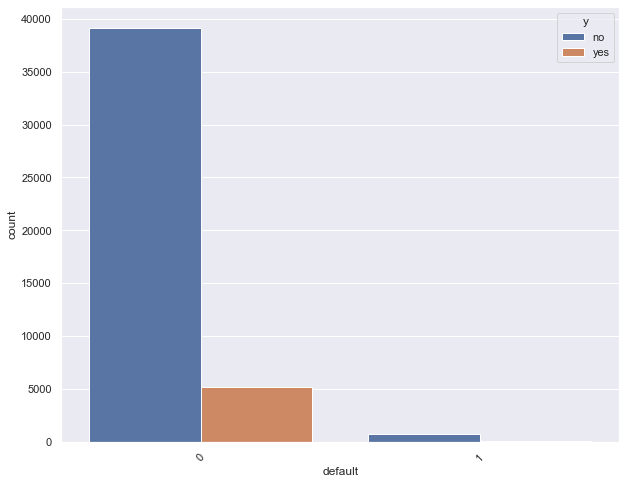

Categorical Variable: housing


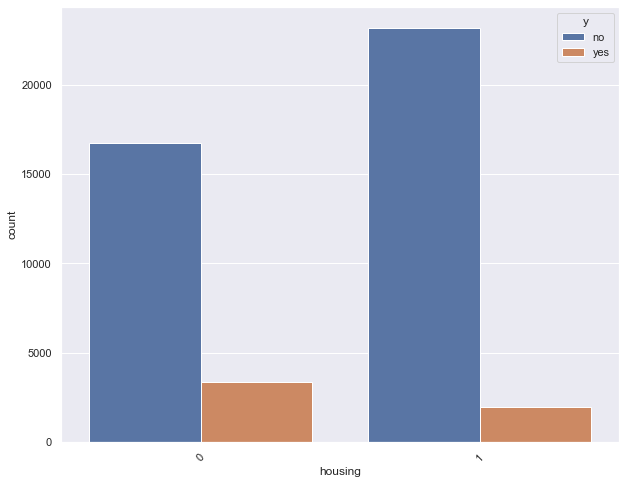

Categorical Variable: loan


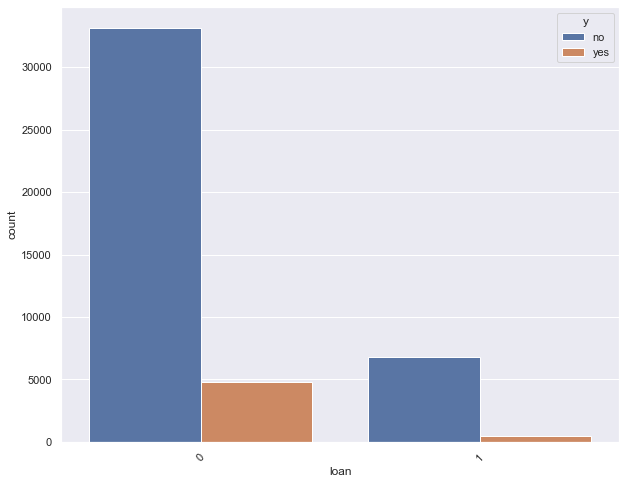

Categorical Variable: contact


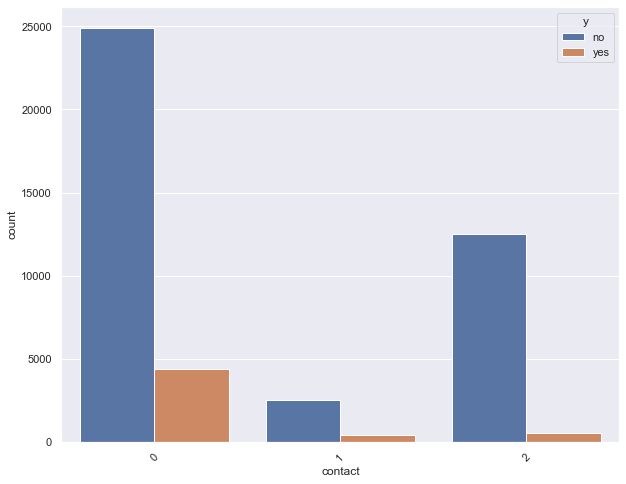

Categorical Variable: month


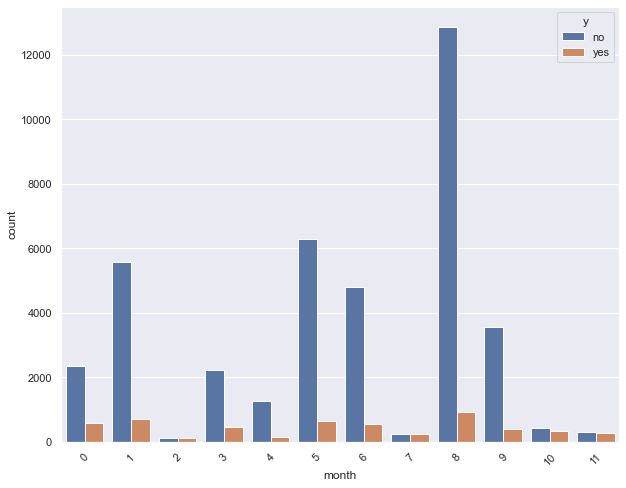

Categorical Variable: poutcome


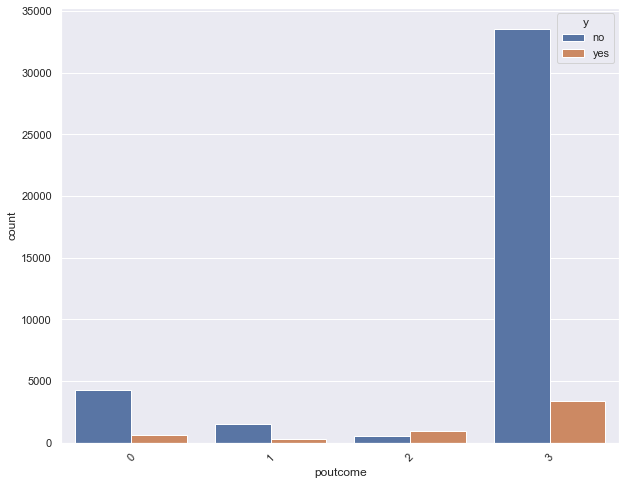

In [19]:
# Посмотрим на категориальные признаки
for cat_var in cat_vars:
    print("Categorical Variable: {}".format(cat_var))
    plt.figure(figsize=(10,8))
    sns.countplot(x=cat_var, hue=target, data=df)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=45)
    plt.show()

In [20]:
# Поменяем категориальные признаки 
for cat_col in cat_vars:
    df[cat_col] = df[cat_col].astype('category')

In [21]:
cat_columns = df.select_dtypes(['category']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  int8  
 2   marital    45211 non-null  int8  
 3   education  45211 non-null  int8  
 4   default    45211 non-null  int8  
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  int8  
 7   loan       45211 non-null  int8  
 8   contact    45211 non-null  int8  
 9   day        45211 non-null  int64 
 10  month      45211 non-null  int8  
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  int8  
 16  y          45211 non-null  object
dtypes: int64(7), int8(9), object(1)
memory usage: 3.1+ MB


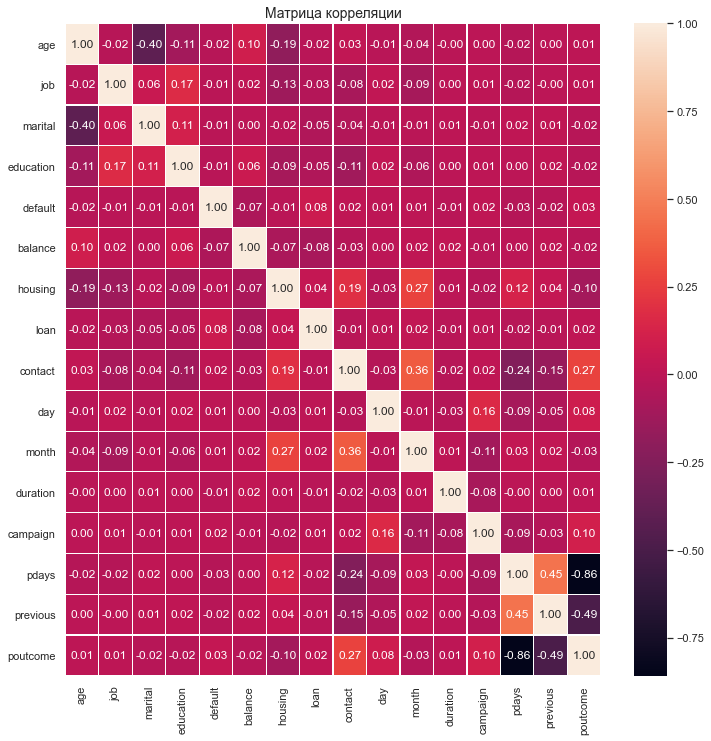

In [23]:
df_corr = df.drop('y', 1).corr()
f, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(df_corr, annot=True, linewidths=0.1, fmt='.2f', ax=ax)
            
plt.title('Матрица корреляции', size=14)
plt.show()

In [24]:
# Изменение целевой переменной
df['y'] = df['y'].map({'no': 0, 'yes': 1})

#### Обучить любой классификатор (какой вам нравится)

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop('y', 1), df['y'], random_state=42)

In [26]:
X_train.shape

(33908, 16)

In [27]:
y_train.shape

(33908,)

In [30]:
import xgboost as xgb

In [31]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
y_predict_proba = model.predict_proba(X_test)[:, 1]

[20:38:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [32]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [33]:
precision, recall, thresholds = precision_recall_curve(y_test, y_predict)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%.3f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

roc_auc = roc_auc_score(y_true=y_test, y_score=y_predict)

Best Threshold=1.000, F-Score=0.551, Precision=0.645, Recall=0.480


#### Разобраться с SHAP и построить важности признаков

In [34]:
import shap
# load JS visualization code to notebook
shap.initjs()

#### всего тестового набора данных (summary_plot - дать интерпретацию)

In [35]:
model = xgb.train({"learning_rate": 0.01}, 
                      xgb.DMatrix(X_train, label=y_train), 100)

# строим модель объЯсненияе в SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# покажем объяснение первого примера (берем matplotlib=True для обхода Javascript)
shap.initjs() # для работы в колаборатории 
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

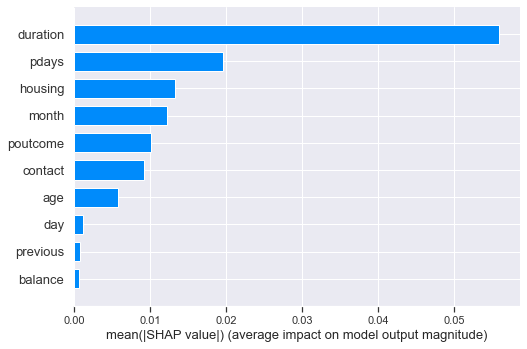

In [36]:
shap.summary_plot(shap_values=shap_values, features=X_test, plot_type='bar', max_display=10)

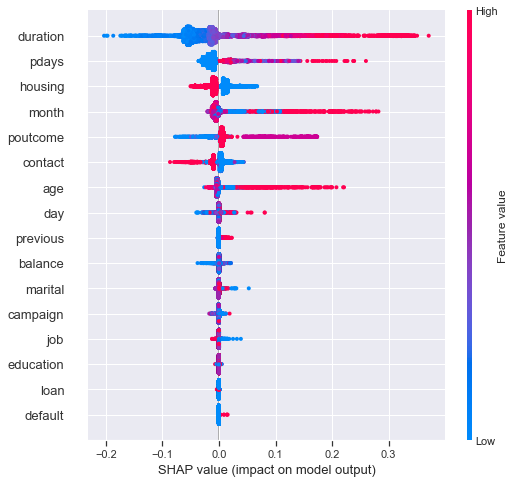

In [37]:
shap.summary_plot(shap_values, X_test)

#### для топ 10%

In [41]:
preds = y_predict_proba
X_test_10 = X_test
#Подсчитал модуль разницы между y_test и предсказанными значениями
dif = np.abs(y_test - preds).reset_index(drop=True)
X_test_10['dif'] = dif
length_10 = round(len(X_test_10) * 0.1)
#отсортировал по этому модулю и взял 10% значений с минимальной разницей
X_test_10 = X_test_10.sort_values(by=['dif']).iloc[: length_10, :]
X_test_10 = X_test_10.drop('dif', 1)

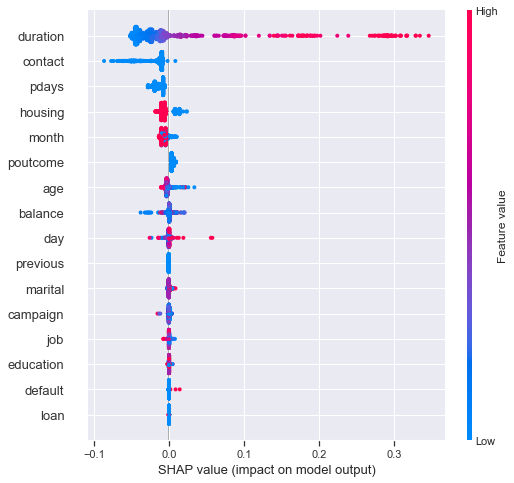

In [42]:
shap_values = explainer.shap_values(X_test_10)
shap.summary_plot(shap_values, X_test_10)

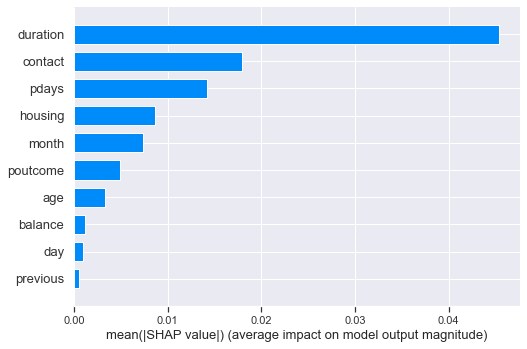

In [43]:
shap.summary_plot(shap_values=shap_values, features=X_test_10, plot_type='bar', max_display=10)

#### для отдельных наблюдений вывести force_plot

In [44]:
def force_plot(sample_number):
    display(
        pd.DataFrame(df.iloc[sample_number, :]).T,
        shap.force_plot(explainer.expected_value, shap_values[sample_number, :], X_train.iloc[sample_number, :]))

In [45]:
force_plot(sample_number=42)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
42,60,1,1,3,0,104,1,0,2,5,8,22,1,-1,0,3,0
